# DQN Training with Load & Save (Geometry Dash)
Entrenamiento igual al flujo original, **con carga previa opcional** y **guardado** al final usando
**`geometryDQN_Savefile.pth`** como único archivo de checkpoint.

- Carga *si existe* y si `LOAD_FROM_CHECKPOINT = True`.
- Guarda siempre al terminar el entrenamiento.
- Gráficas: recompensa por episodio y epsilon.


In [23]:

from gd_env import GeometryEnv
from model import Agent
import torch
import numpy as np
import matplotlib.pyplot as plt


In [24]:

# --- Configuración ---
CHECKPOINT_PATH = "geometryDQN_Savefile.pth"
LOAD_FROM_CHECKPOINT = True   # ponlo en False si quieres ignorar el .pth existente

# --- Crear entorno y agente ---
env = GeometryEnv()
state_size = len(env.get_state())
action_size = 2  # 0: no saltar, 1: saltar

agent = Agent(state_size, action_size)

# --- Carga opcional de pesos antes de entrenar ---
if LOAD_FROM_CHECKPOINT:
    try:
        agent.model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location="cpu"))
        agent.update_target_model()  # sincroniza red objetivo con los pesos cargados
        print(f"[LOAD] Cargado checkpoint desde: {CHECKPOINT_PATH}")
    except FileNotFoundError:
        print(f"[LOAD] No se encontró {CHECKPOINT_PATH}. Se entrenará desde cero.")
    except Exception as ex:
        print(f"[LOAD] No se pudo cargar el checkpoint ({CHECKPOINT_PATH}): {ex}\n"
              f"Se continuará entrenando desde cero.")


[LOAD] Cargado checkpoint desde: geometryDQN_Savefile.pth


In [25]:

# --- Entrenamiento (idéntico a tu flujo original) ---
episodes = 500
batch_size = 64

# Almacenar métricas
rewards_history = []
epsilon_history = []

for e in range(episodes):
    state = env.reset()
    total_reward = 0.0
    for t in range(1000):  # pasos por episodio
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        total_reward += reward

        agent.replay(batch_size)
        if done:
            agent.update_target_model()
            break

    rewards_history.append(total_reward)
    epsilon_history.append(agent.epsilon)

    print("Ep", e + 1, "/", episodes,
          "| Recompensa total:", round(total_reward, 2),
          "| Epsilon:", round(agent.epsilon, 3))

# Guardar modelo SIEMPRE al finalizar con el nombre fijo
torch.save(agent.model.state_dict(), CHECKPOINT_PATH)
print(f"[SAVE] Guardado checkpoint en: {CHECKPOINT_PATH}")


Ep 1 / 500 | Recompensa total: -2.0 | Epsilon: 0.483
Ep 2 / 500 | Recompensa total: 29.0 | Epsilon: 0.05
Ep 3 / 500 | Recompensa total: 2.0 | Epsilon: 0.05
Ep 4 / 500 | Recompensa total: 8.0 | Epsilon: 0.05
Ep 5 / 500 | Recompensa total: 13.0 | Epsilon: 0.05
Ep 6 / 500 | Recompensa total: 9.0 | Epsilon: 0.05
Ep 7 / 500 | Recompensa total: 1.0 | Epsilon: 0.05
Ep 8 / 500 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 9 / 500 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 10 / 500 | Recompensa total: 10.0 | Epsilon: 0.05
Ep 11 / 500 | Recompensa total: 7.0 | Epsilon: 0.05
Ep 12 / 500 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 13 / 500 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 14 / 500 | Recompensa total: 38.0 | Epsilon: 0.05
Ep 15 / 500 | Recompensa total: -2.0 | Epsilon: 0.05
Ep 16 / 500 | Recompensa total: -5.0 | Epsilon: 0.05
Ep 17 / 500 | Recompensa total: 4.0 | Epsilon: 0.05
Ep 18 / 500 | Recompensa total: 39.0 | Epsilon: 0.05
Ep 19 / 500 | Recompensa total: 1.0 | Epsilon: 0.05
Ep 20 / 

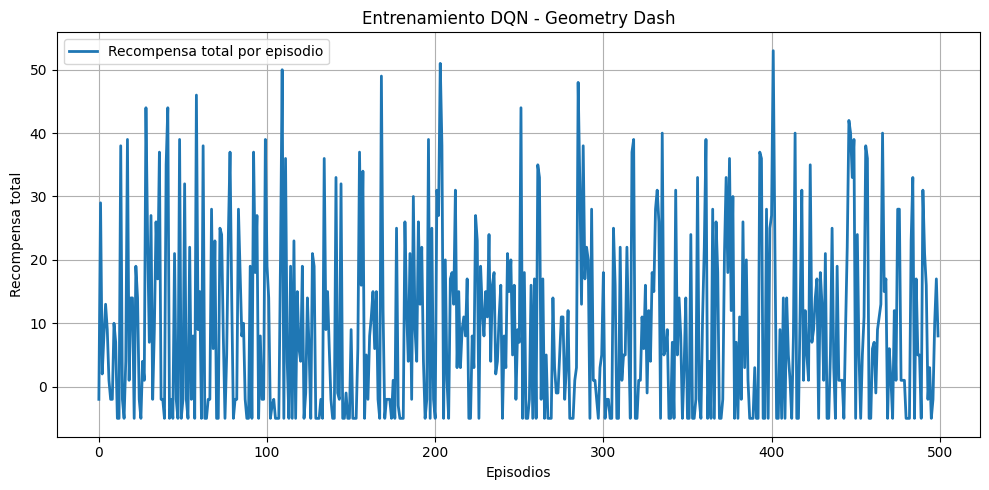

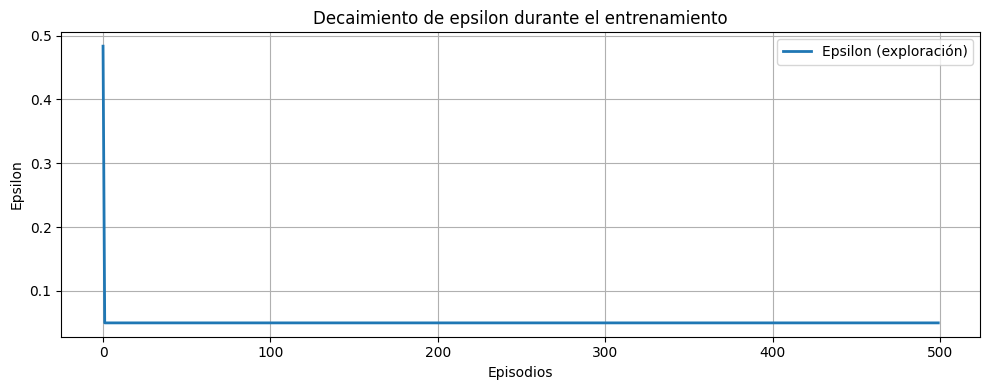

In [26]:

# --- Gráficas ---
plt.figure(figsize=(10,5))
plt.plot(rewards_history, label="Recompensa total por episodio", linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Recompensa total")
plt.title("Entrenamiento DQN - Geometry Dash")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(epsilon_history, label="Epsilon (exploración)", linewidth=2)
plt.xlabel("Episodios")
plt.ylabel("Epsilon")
plt.title("Decaimiento de epsilon durante el entrenamiento")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


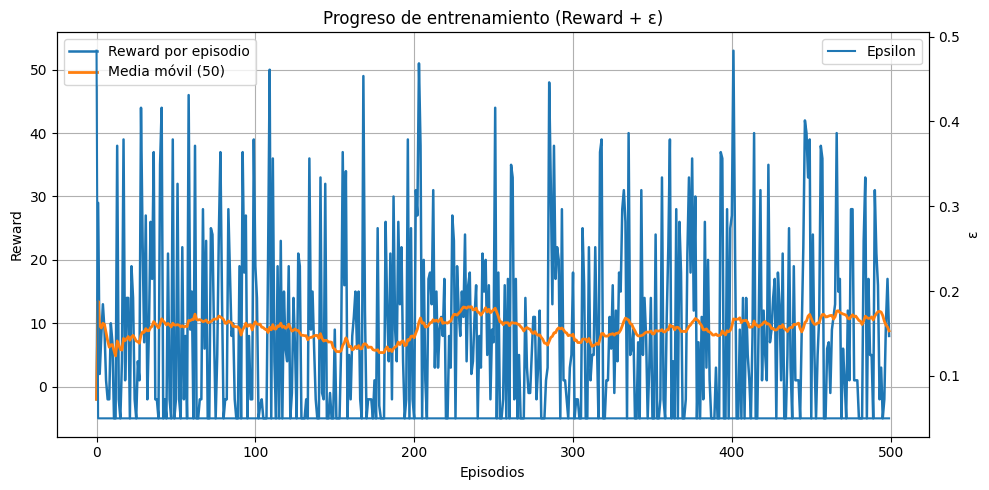

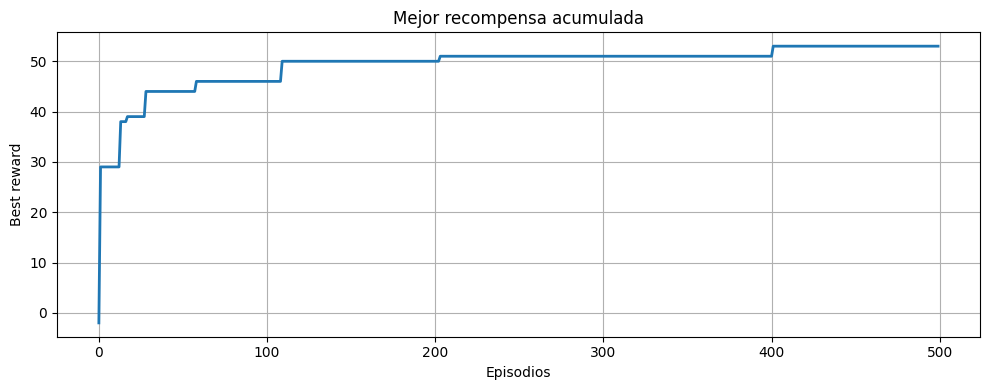

In [27]:
# ==== Media móvil + gráfico combinado (reward + epsilon) ====
from collections import deque
import numpy as np
import matplotlib.pyplot as plt

def moving_avg(seq, w=50):
    out, q, s = [], deque(), 0.0
    for v in seq:
        q.append(v); s += v
        if len(q) > w:
            s -= q.popleft()
        out.append(s/len(q))
    return out

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(rewards_history, label="Reward por episodio", linewidth=1.8)
ma = moving_avg(rewards_history, w=50)
if len(ma) == len(rewards_history):
    ax1.plot(ma, label="Media móvil (50)", linewidth=2)
ax1.set_xlabel("Episodios"); ax1.set_ylabel("Reward")
ax1.grid(True); ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(epsilon_history, label="Epsilon", linewidth=1.5)
ax2.set_ylabel("ε")
ax2.legend(loc="upper right")
plt.title("Progreso de entrenamiento (Reward + ε)")
plt.tight_layout(); plt.show()

# (extra) mejor reward acumulado para ver “SOTA personal”
best_so_far, curve = -1e9, []
for r in rewards_history:
    best_so_far = max(best_so_far, r)
    curve.append(best_so_far)
plt.figure(figsize=(10,4))
plt.plot(curve, linewidth=2)
plt.title("Mejor recompensa acumulada"); plt.xlabel("Episodios"); plt.ylabel("Best reward")
plt.grid(True); plt.tight_layout(); plt.show()


Random  -> reward(mean±sd): (-0.65, 4.362052269287932)  length: (165.1, 73.91880680855178)  obs: (4.35, 4.362052269287932)
Greedy  -> reward(mean±sd): (51.0, 29.24038303442689)  length: (1654.2, 1370.8476793575574)  obs: (56.0, 29.24038303442689)


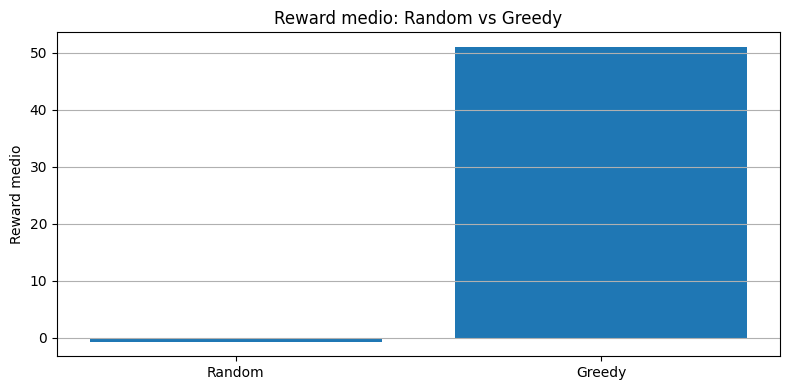

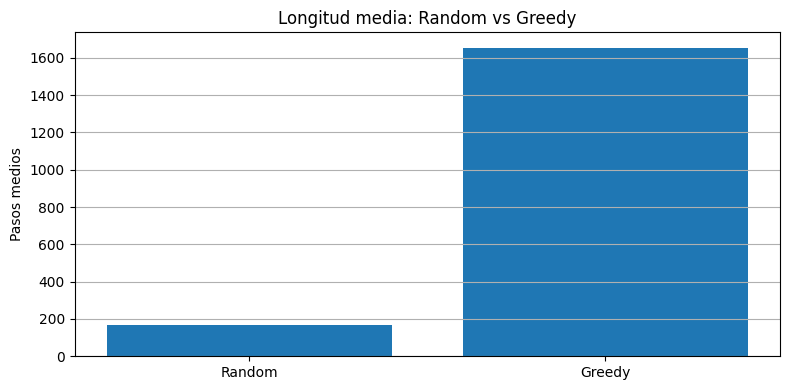

In [28]:
# ==== Evaluación: random vs greedy (sin reentrenar) ====
import numpy as np
import torch

def eval_policy(model, episodes=20, epsilon=None):
    """
    epsilon=None -> greedy puro; epsilon=1.0 -> random puro; epsilon=0.05 -> casi greedy.
    Devuelve dict con medias y desv. estándar de reward, length y 'obstacles' (si tu reward cuenta obstáculos).
    """
    stats = {"reward": [], "length": [], "obstacles": []}
    for _ in range(episodes):
        e = GeometryEnv()
        s = e.reset()
        done = False
        ep_rew = 0.0; ep_len = 0; ep_obs = 0.0
        while not done:
            if epsilon is None:   # greedy
                with torch.no_grad():
                    q = agent.model(torch.tensor(s, dtype=torch.float32).unsqueeze(0))
                    a = int(q.argmax(dim=1).item())
            else:
                if np.random.rand() < epsilon:
                    a = np.random.randint(0, 2)
                else:
                    with torch.no_grad():
                        q = agent.model(torch.tensor(s, dtype=torch.float32).unsqueeze(0))
                        a = int(q.argmax(dim=1).item())
            s2, r, done, info = e.step(a)
            ep_rew += r; ep_len += 1
            if r > 0: ep_obs += r  # ajústalo si tu shaping no es +1 por obstáculo
            s = s2
        stats["reward"].append(ep_rew)
        stats["length"].append(ep_len)
        stats["obstacles"].append(ep_obs)
    return {k: (float(np.mean(v)), float(np.std(v))) for k,v in stats.items()}

rand_stats = eval_policy(agent.model, episodes=20, epsilon=1.0)
greedy_stats = eval_policy(agent.model, episodes=20, epsilon=None)

print("Random  -> reward(mean±sd):", rand_stats["reward"], " length:", rand_stats["length"], " obs:", rand_stats["obstacles"])
print("Greedy  -> reward(mean±sd):", greedy_stats["reward"], " length:", greedy_stats["length"], " obs:", greedy_stats["obstacles"])

# Barras (mean)
labels = ["Random","Greedy"]
means_reward = [rand_stats["reward"][0], greedy_stats["reward"][0]]
means_length = [rand_stats["length"][0], greedy_stats["length"][0]]

plt.figure(figsize=(8,4))
plt.bar(labels, means_reward)
plt.title("Reward medio: Random vs Greedy")
plt.ylabel("Reward medio"); plt.grid(True, axis="y"); plt.tight_layout(); plt.show()

plt.figure(figsize=(8,4))
plt.bar(labels, means_length)
plt.title("Longitud media: Random vs Greedy")
plt.ylabel("Pasos medios"); plt.grid(True, axis="y"); plt.tight_layout(); plt.show()
